In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn')

In [8]:
# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Display first few rows of each dataset
print("Customers Dataset:")
print(customers_df.head())
print("\nProducts Dataset:")
print(products_df.head())
print("\nTransactions Dataset:")
print(transactions_df.head())

Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166   

In [9]:
# Task 1: Exploratory Data Analysis (EDA)

# Basic information about datasets
print("Customers Dataset Info:")
print(customers_df.info())
print("\nProducts Dataset Info:")
print(products_df.info())
print("\nTransactions Dataset Info:")
print(transactions_df.info())

# Check for missing values
print("\nMissing Values:")
print("Customers:", customers_df.isnull().sum())
print("Products:", products_df.isnull().sum())
print("Transactions:", transactions_df.isnull().sum())

Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   C

In [10]:
# Basic statistics
print("Customer Statistics:")
print(customers_df.describe())
print("\nProduct Statistics:")
print(products_df.describe())
print("\nTransaction Statistics:")
print(transactions_df.describe())

# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

Customer Statistics:
       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3

Product Statistics:
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000

Transaction Statistics:
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


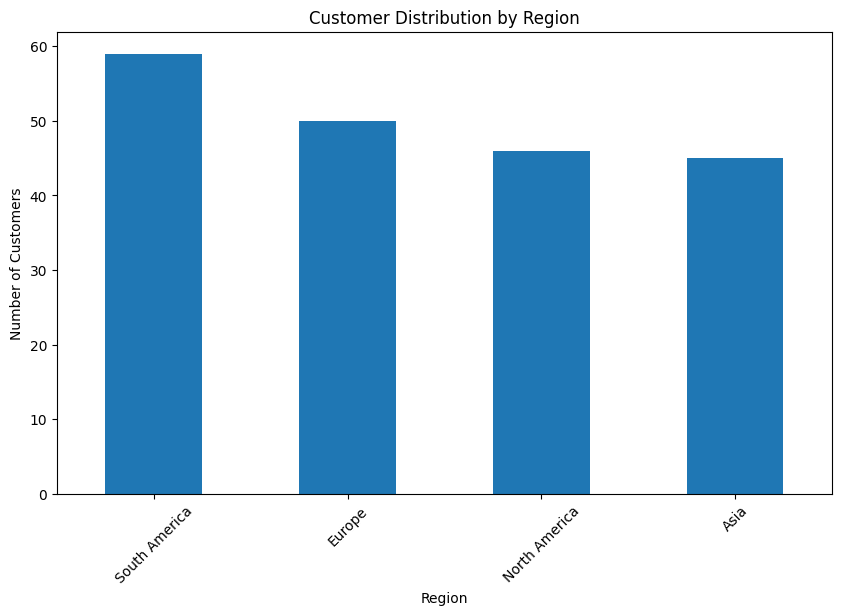

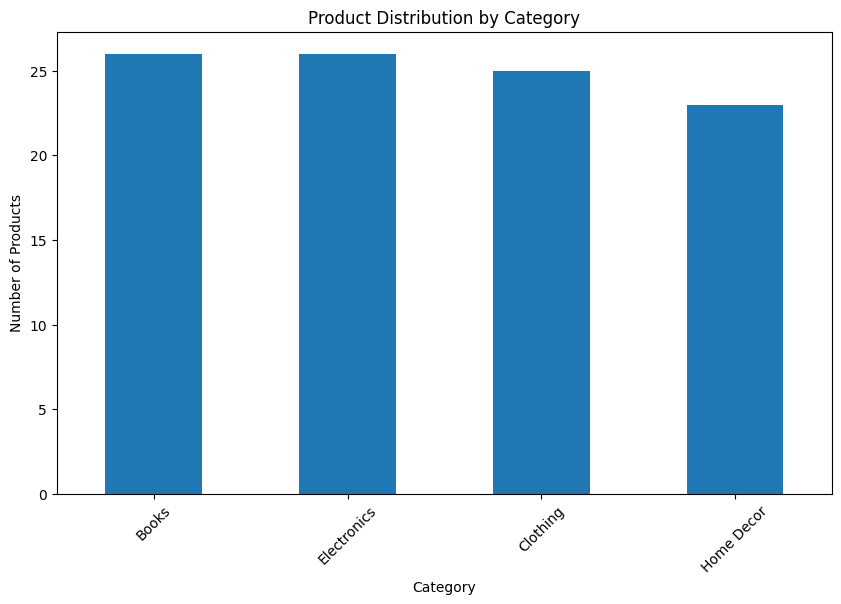

In [11]:
# Visualization 1: Customer Distribution by Region
plt.figure(figsize=(10, 6))
customers_df['Region'].value_counts().plot(kind='bar')
plt.title('Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# Visualization 2: Product Categories Distribution
plt.figure(figsize=(10, 6))
products_df['Category'].value_counts().plot(kind='bar')
plt.title('Product Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Task 2: Lookalike Model

def create_customer_features(customers_df, transactions_df):
    # Calculate customer metrics
    customer_metrics = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean'],
        'TransactionID': 'count'
    }).reset_index()
    
    customer_metrics.columns = ['CustomerID', 'Total_Spend', 'Avg_Transaction_Value', 
                              'Total_Quantity', 'Avg_Quantity', 'Transaction_Count']
    
    # Merge with customer information
    customer_features = customers_df.merge(customer_metrics, on='CustomerID')
    
    return customer_features

# Create customer features
customer_features = create_customer_features(customers_df, transactions_df)

# Prepare features for similarity calculation
features_for_similarity = ['Total_Spend', 'Avg_Transaction_Value', 'Total_Quantity', 
                         'Avg_Quantity', 'Transaction_Count']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[features_for_similarity])

# Calculate similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

# Function to get top 3 similar customers
def get_top_3_similar(customer_id, customer_features, similarity_matrix):
    customer_index = customer_features[customer_features['CustomerID'] == customer_id].index[0]
    similarities = similarity_matrix[customer_index]
    similar_indices = np.argsort(similarities)[::-1][1:4]  # Get top 3 excluding self
    
    similar_customers = []
    for idx in similar_indices:
        similar_customers.append({
            'customer_id': customer_features.iloc[idx]['CustomerID'],
            'similarity_score': similarities[idx]
        })
    
    return similar_customers

# Generate lookalike recommendations for first 20 customers
lookalike_results = {}
for customer_id in customers_df['CustomerID'][:20]:
    lookalike_results[customer_id] = get_top_3_similar(customer_id, customer_features, similarity_matrix)

# Save results to CSV
lookalike_df = pd.DataFrame([(k, str(v)) for k, v in lookalike_results.items()], 
                           columns=['CustomerID', 'Similar_Customers'])
lookalike_df.to_csv('Lookalike.csv', index=False)

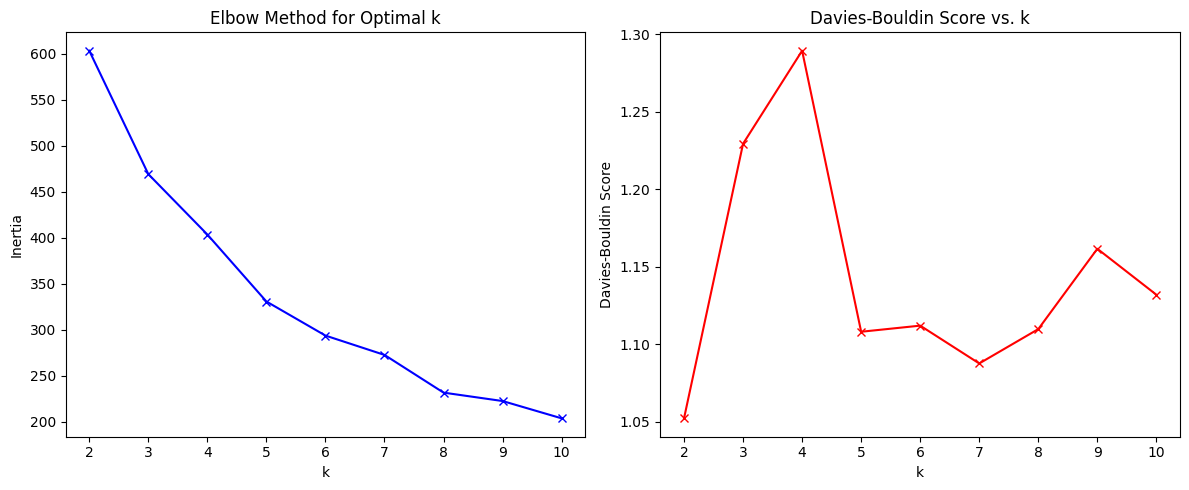

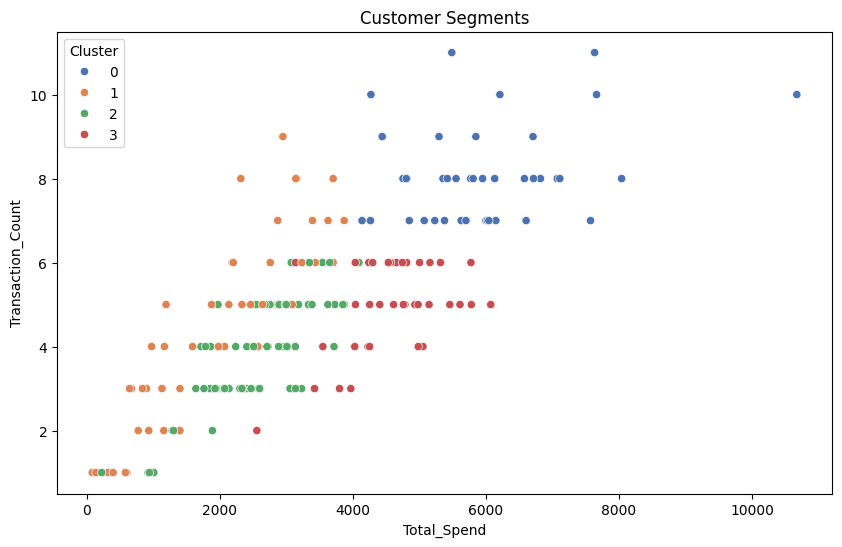

Final Davies-Bouldin Index: 1.2893322309488089

Cluster Analysis:
         Total_Spend  Avg_Transaction_Value  Total_Quantity  Avg_Quantity  \
Cluster                                                                     
0        5989.599250             746.877024       21.600000      2.672772   
1        1904.363478             419.653046        8.065217      1.827553   
2        2543.816711             688.809866        9.921053      2.651974   
3        4580.562162             954.048252       14.810811      3.002703   

         Transaction_Count  
Cluster                     
0                 8.100000  
1                 4.391304  
2                 3.815789  
3                 4.972973  


In [13]:
# Task 3: Customer Segmentation

# Prepare features for clustering
clustering_features = ['Total_Spend', 'Avg_Transaction_Value', 'Total_Quantity', 
                      'Avg_Quantity', 'Transaction_Count']
X = customer_features[clustering_features]

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

# Find optimal number of clusters using elbow method
inertias = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, db_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs. k')
plt.tight_layout()
plt.show()

# Perform final clustering with optimal k (let's say k=4 for this example)
optimal_k = 4
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='Total_Spend', y='Transaction_Count', 
                hue='Cluster', palette='deep')
plt.title('Customer Segments')
plt.show()

# Calculate final Davies-Bouldin Index
final_db_score = davies_bouldin_score(X_scaled, customer_features['Cluster'])
print(f"Final Davies-Bouldin Index: {final_db_score}")

# Analyze clusters
cluster_analysis = customer_features.groupby('Cluster')[clustering_features].mean()
print("\nCluster Analysis:")
print(cluster_analysis)